In [2]:
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from tensorflow.keras import layers, models, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import kagglehub
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
import tensorflow as tf

In [3]:
# Download latest version
path = kagglehub.dataset_download("sayeemmohammed/eeg-spectrogram-images")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/eeg-spectrogram-images


In [4]:
# Paths
train_dir = path + "/Alcohol Data (12 channel)/Train/"
test_dir = path + "/Alcohol Data (12 channel)/Test/"
# Image parameters
class_names = ['non_alcoholic', 'alcoholic']

def check_class_balance(directory, class_names):
    counts = {}
    for class_name in class_names:
        class_dir = os.path.join(directory, class_name)
        if os.path.exists(class_dir):
            counts[class_name] = len(os.listdir(class_dir))
    return counts

# Verify the class balance in the training and testing directories
train_balance = check_class_balance(train_dir, class_names)
test_balance = check_class_balance(test_dir, class_names)
print(f"Train class balance: {train_balance}")
print(f"Test class balance: {test_balance}")

Train class balance: {'non_alcoholic': 2875, 'alcoholic': 2875}
Test class balance: {'non_alcoholic': 725, 'alcoholic': 725}


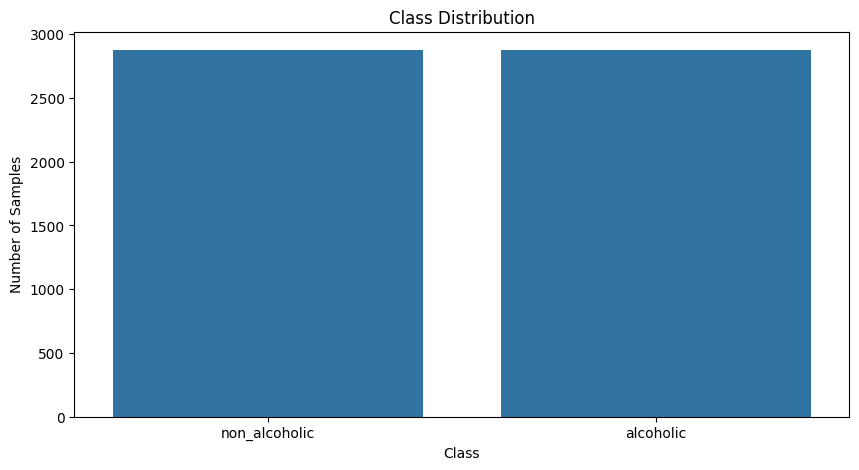

In [5]:
def plot_class_distribution(directory, class_names):
    counts = check_class_balance(directory, class_names)
    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(counts.keys()), y=list(counts.values()))
    plt.title('Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Number of Samples')
    plt.show()

plot_class_distribution(train_dir, class_names)


In [6]:
def check_image_shapes(directory, class_names):
    shapes = {}
    for class_name in class_names:
        class_dir = os.path.join(directory, class_name)
        if os.path.exists(class_dir):
            for img_file in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_file)
                img = tf.keras.preprocessing.image.load_img(img_path)
                shapes[class_name] = img.size
                break  # Stop after the first image

    return shapes

train_shapes = check_image_shapes(train_dir, class_names)
test_shapes = check_image_shapes(test_dir, class_names)
print(f"Train image shapes: {train_shapes}")
print(f"Test image shapes: {test_shapes}")

Train image shapes: {'non_alcoholic': (640, 480), 'alcoholic': (640, 480)}
Test image shapes: {'non_alcoholic': (640, 480), 'alcoholic': (640, 480)}


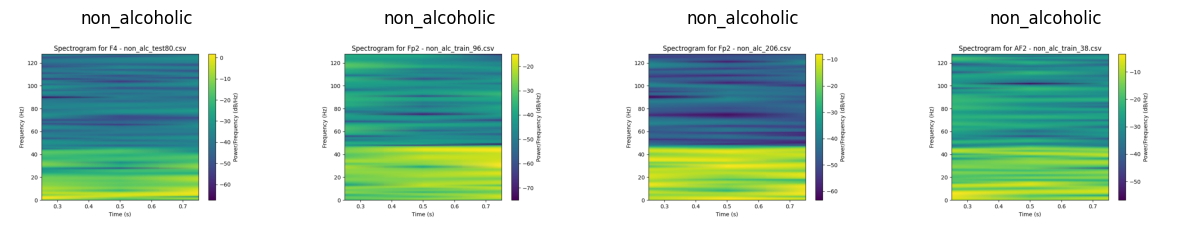

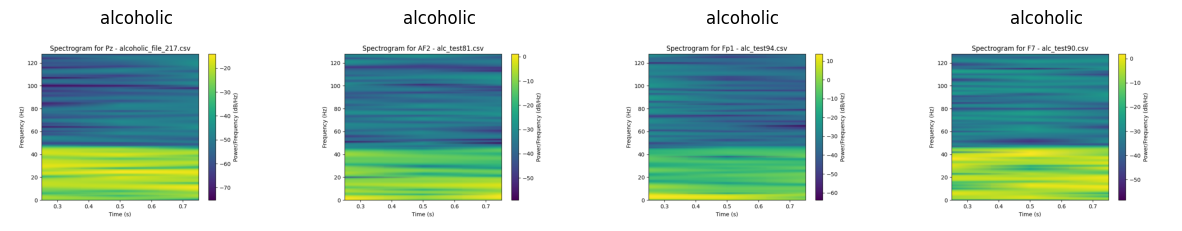

In [7]:
def show_random_images(directory, class_name, num_images=4):
    class_path = os.path.join(directory, class_name)
    images = os.listdir(class_path)
    random_images = np.random.choice(images, num_images, replace=False)

    plt.figure(figsize=(15, 5))
    for i, img_file in enumerate(random_images):
        img_path = os.path.join(class_path, img_file)
        img = Image.open(img_path)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(class_name)
    plt.show()

show_random_images(train_dir, 'non_alcoholic')
show_random_images(train_dir, 'alcoholic')

In [8]:
# Parameters
img_size = (150, 150)
batch_size = 32
seed = 123

# Preprocessing without augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
)
test_datagen = ImageDataGenerator(rescale=1./255)

# Train, validation and test generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    shuffle=True,
    seed=seed
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    seed=seed
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)


Found 4600 images belonging to 2 classes.
Found 1150 images belonging to 2 classes.
Found 1450 images belonging to 2 classes.


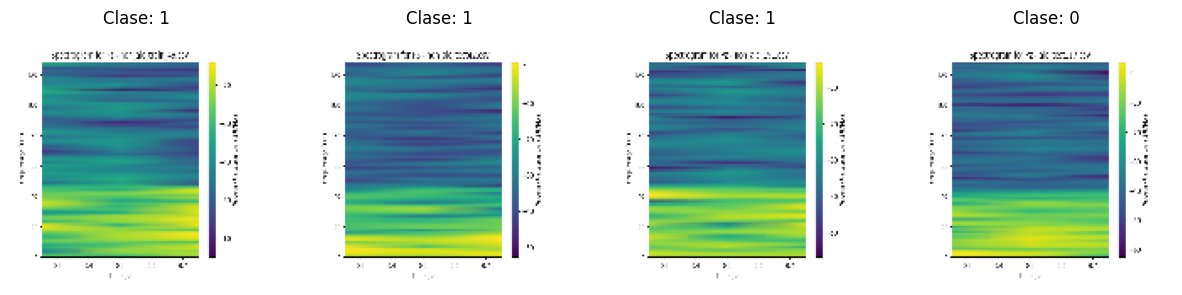

In [9]:
sample_images, sample_labels = next(train_generator)
num_samples_to_show = 4

plt.figure(figsize=(15, 5))
for i in range(num_samples_to_show):
    plt.subplot(1, num_samples_to_show, i + 1)
    plt.imshow(sample_images[i])
    plt.title(f"Clase: {int(sample_labels[i])}")
    plt.axis('off')

# Show some sample images
plt.show()

In [10]:
# Shape of the images and labels
print("Images shapes:", sample_images.shape)
print("Labels shapes:", sample_labels.shape)
print("Label example:", sample_labels[0])

# True labels
y_train = train_generator.classes
class_labels = np.unique(y_train)

Images shapes: (32, 150, 150, 3)
Labels shapes: (32,)
Label example: 1.0


In [ ]:
# Define model
input_layer = Input(shape=(150, 150, 3))

x = layers.Conv2D(32, (3,3), activation='relu')(input_layer)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(2,2)(x)

x = layers.Conv2D(64, (3,3), activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(2,2)(x)

x = layers.Conv2D(128, (3,3), activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(2,2)(x)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output_layer = layers.Dense(1, activation='sigmoid')(x)

model = models.Model(inputs=input_layer, outputs=output_layer)

# Compile model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 72, 72, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 34, 34, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 102,465 (400.25 KB)

 Trainable params: 102,017 (398.50 KB)

 Non-trainable params: 448 (1.75 KB)

In [12]:
# Callbacks to monitor the training process
callbacks = [
    ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
]

# Train the model
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator,
    callbacks=callbacks
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
144/144 ━━━━━━━━━━━━━━━━━━━━ 81s 509ms/step - accuracy: 0.6034 - loss: 0.6476 - val_accuracy: 0.5000 - val_loss: 0.8597 - learning_rate: 0.0010
Epoch 2/5
144/144 ━━━━━━━━━━━━━━━━━━━━ 49s 344ms/step - accuracy: 0.9836 - loss: 0.0800 - val_accuracy: 0.8896 - val_loss: 0.5117 - learning_rate: 0.0010
Epoch 3/5
144/144 ━━━━━━━━━━━━━━━━━━━━ 48s 333ms/step - accuracy: 0.9994 - loss: 0.0101 - val_accuracy: 0.9687 - val_loss: 0.2154 - learning_rate: 0.0010
Epoch 4/5
144/144 ━━━━━━━━━━━━━━━━━━━━ 48s 331ms/step - accuracy: 0.9994 - loss: 0.0039 - val_accuracy: 0.8948 - val_loss: 0.1838 - learning_rate: 0.0010
Epoch 5/5
144/144 ━━━━━━━━━━━━━━━━━━━━ 48s 335ms/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 0.9157 - val_loss: 0.1927 - learning_rate: 0.0010


In [13]:
# Get model predictions
preds= model.predict(test_generator)
Y_pred = (preds > 0.5).astype("int32")

46/46 ━━━━━━━━━━━━━━━━━━━━ 16s 336ms/step


Accuracy: 1.0
Validation Accuracy: 0.9156521558761597
Loss: 0.0011893257033079863
Validation Loss: 0.19265130162239075


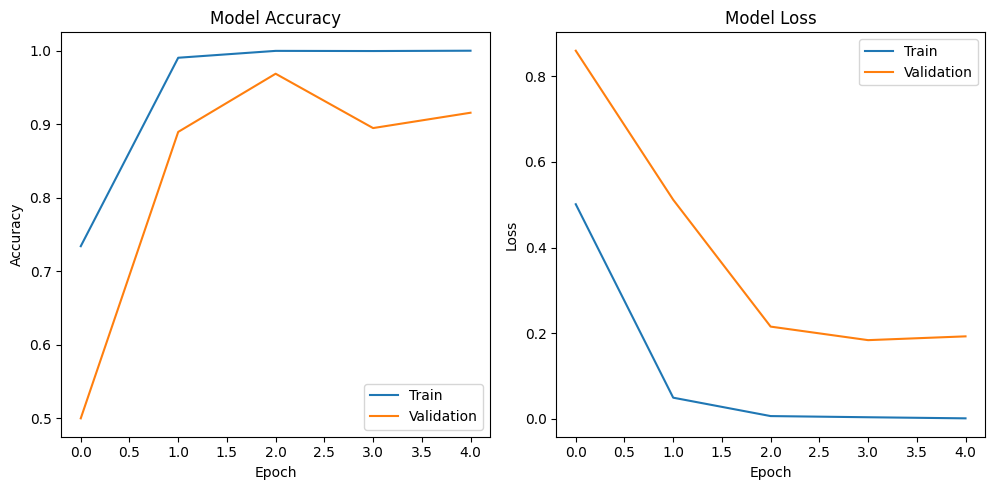

In [14]:
# Plot training metrics
plt.figure(figsize=(15, 5))

# Accuracy plot
print("Accuracy:", history.history['accuracy'][-1])
print("Validation Accuracy:", history.history['val_accuracy'][-1])
plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

# Loss plot
print("Loss:", history.history['loss'][-1])
print("Validation Loss:", history.history['val_loss'][-1])
plt.subplot(1, 3, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.savefig('training_metrics.png')
plt.show()


Min pred: 0
Max pred: 1
Mean pred: 0.4917241379310345
{'alcoholic': 0, 'non_alcoholic': 1}
4.692091e-06 0.99982905 0.46990842
[[725   0]
 [ 12 713]]


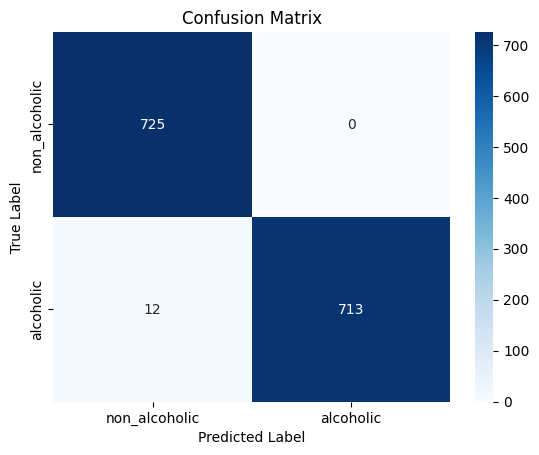

Classification Report
              precision    recall  f1-score   support

        Test       0.98      1.00      0.99       725
       Train       1.00      0.98      0.99       725

    accuracy                           0.99      1450
   macro avg       0.99      0.99      0.99      1450
weighted avg       0.99      0.99      0.99      1450



In [15]:
# True labels of the test set
y_true = test_generator.classes

print("Min pred:", Y_pred.min())
print("Max pred:", Y_pred.max())
print("Mean pred:", Y_pred.mean())
print(train_generator.class_indices)
print(np.min(preds), np.max(preds), np.mean(preds))


# Confusion matrix
cm = confusion_matrix(y_true, Y_pred)
print(cm)

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["non_alcoholic", "alcoholic"], yticklabels=["non_alcoholic", "alcoholic"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Classification report
print("Classification Report")
print(classification_report(y_true, Y_pred, target_names=["Test", "Train"]))

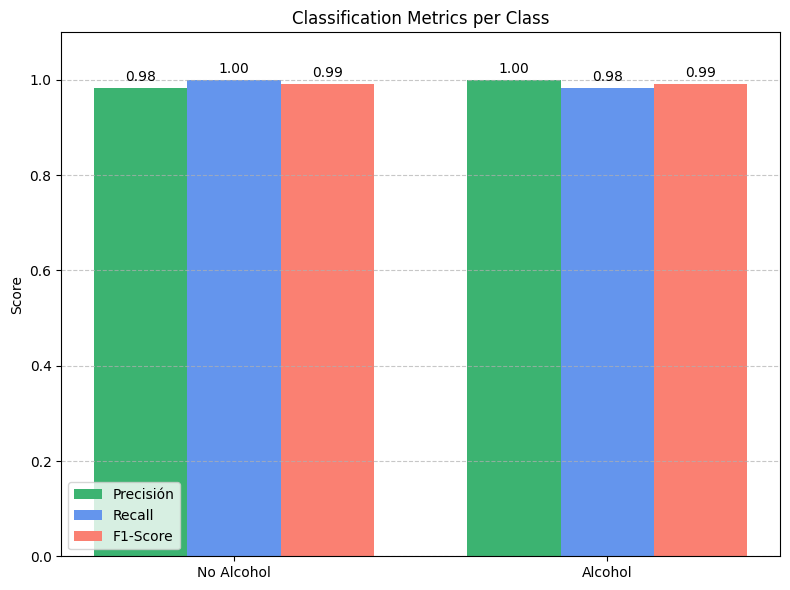

In [16]:
# Plot classification metrics per class
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, Y_pred)
labels = ['No Alcohol', 'Alcohol']

x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots(figsize=(8, 6))
bars1 = ax.bar(x - width, precision, width, label='Precisión', color='mediumseagreen')
bars2 = ax.bar(x, recall, width, label='Recall', color='cornflowerblue')
bars3 = ax.bar(x + width, f1_score, width, label='F1-Score', color='salmon')

for bar_group in [bars1, bars2, bars3]:
    for bar in bar_group:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

ax.set_ylabel('Score')
ax.set_title('Classification Metrics per Class')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.ylim(0, 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [17]:
model.save("EEG_Model.keras")

46/46 ━━━━━━━━━━━━━━━━━━━━ 13s 283ms/step


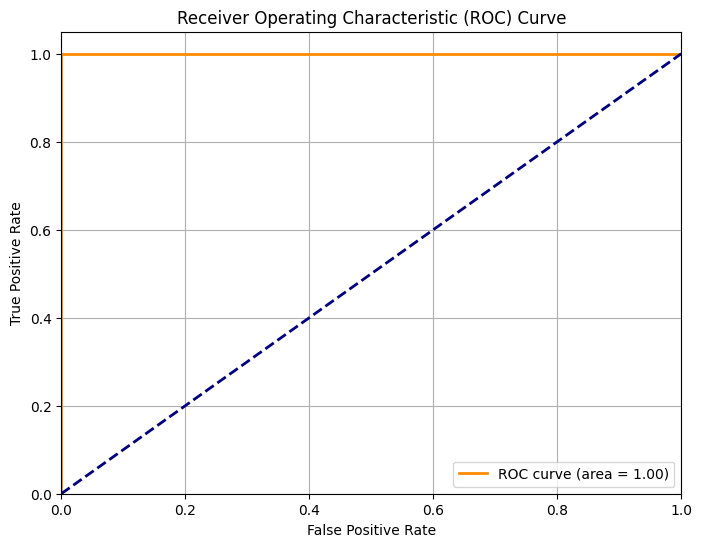

AUC: 1.00


In [19]:
# prompt: genera el codigo para obtener la curva roc de el modelo anterior

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Get the predicted probabilities for the positive class (class 1 - alcoholic)
y_pred_prob = model.predict(test_generator).ravel()

# Calculate the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)

# Calculate the Area Under the ROC Curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print(f"AUC: {roc_auc:.2f}")